## Tellusで干渉SARをやってみた（DEM編）

YOUR-TOKEN を、ご自身のTellus開発環境のトークンに置き換えて下さい。
参考：APIキーの取得方法<https://sorabatake.jp/5048>

### 干渉ペアをダウンロードする

In [1]:
import os, requests
import numpy as np

TOKEN = "YOUR-TOKEN"

def search_palsar2_l11(params={}, next_url=''):
    if len(next_url) > 0:
        url = next_url
    else:
        url = 'https://file.tellusxdp.com/api/v1/origin/search/palsar2-l11'
    headers = {
        "Authorization": "Bearer " + TOKEN
    }
    
    r = requests.get(url,params=params, headers=headers)
    if not r.status_code == requests.codes.ok:
        r.raise_for_status()
    return r.json()
def publish_palsar2_l11(dataset_id):
    url = 'https://file.tellusxdp.com/api/v1/origin/publish/palsar2-l11/{}'.format(dataset_id)
    headers = {
        "Authorization": "Bearer " + TOKEN
    }
    r = requests.get(url, headers=headers)
    if not r.status_code == requests.codes.ok:
        r.raise_for_status()
    return r.json()
def download_file(url, dir, name):
    headers = {
        "Authorization": "Bearer " + TOKEN
    }
    r = requests.get(url, headers=headers, stream=True)
    if not r.status_code == requests.codes.ok:
        r.raise_for_status()
    if os.path.exists(dir) == False:
        os.makedirs(dir)
    with open(os.path.join(dir,name), "wb") as f:
        for chunk in r.iter_content(chunk_size=1024):
            f.write(chunk)
 
def main():
    #富士山周辺の2シーンをダウンロード
    dataset_id = ['ALOS2176170700-170827','ALOS2229990700-180826']
    for i in range(2):
        published = publish_palsar2_l11(dataset_id[i])
        for file in published['files']:
            file_name = file['file_name']
            file_url = file['url']
            #サムネイル画像、HH偏波の画像、サマリテキストファイル、リーダファイルのみをダウンロードします
            if "jpg" in file_name or "IMG-HH" in file_name or "summary" in file_name or "LED" in file_name:
                print(file_name)
                file = download_file(file_url, dataset_id[i], file_name)
            
if __name__=="__main__":
       main()

BRS-HH-ALOS2176170700-170827-HBQR1.1__A.jpg
BRS-HV-ALOS2176170700-170827-HBQR1.1__A.jpg
BRS-VH-ALOS2176170700-170827-HBQR1.1__A.jpg
BRS-VV-ALOS2176170700-170827-HBQR1.1__A.jpg
IMG-HH-ALOS2176170700-170827-HBQR1.1__A
LED-ALOS2176170700-170827-HBQR1.1__A
summary.txt
BRS-HH-ALOS2229990700-180826-HBQR1.1__A.jpg
BRS-HV-ALOS2229990700-180826-HBQR1.1__A.jpg
BRS-VH-ALOS2229990700-180826-HBQR1.1__A.jpg
BRS-VV-ALOS2229990700-180826-HBQR1.1__A.jpg
IMG-HH-ALOS2229990700-180826-HBQR1.1__A
LED-ALOS2229990700-180826-HBQR1.1__A
summary.txt


### 強度画像と位相画像を出力

In [1]:
import os
import numpy as np
import struct
import matplotlib.pyplot as plt
import math
from io import BytesIO
import cv2

def gen_img(fp,pl):
    fp.seek(236)
    nline = int(fp.read(8))
    fp.seek(248)
    ncell = int(fp.read(8))
    nrec = 544 + ncell*8

    nline = pl[3]-pl[2]
    fp.seek(720)
    fp.seek(int((nrec/4)*(pl[2])*4))
    data = struct.unpack(">%s"%(int((nrec*nline)/4))+"f",fp.read(int(nrec*nline)))
    data = np.array(data).reshape(-1,int(nrec/4))
    data = data[:,int(544/4):]
    data = data[:,::2] + 1j*data[:,1::2]
    data = data[:,pl[0]:pl[1]]
    sigma = 20*np.log10(abs(data)) - 83.0 - 32.0
    phase = np.angle(data)
    sigma = np.array(255*(sigma - np.amin(sigma))/(np.amax(sigma) - np.amin(sigma)),dtype="uint8")
    sigma = cv2.equalizeHist(sigma)
    return sigma, phase

def main():
    dataset_id = ['ALOS2176170700-170827','ALOS2229990700-180826'] #Mt.Fuji
    pl = [2050, 6150, 6450, 12750]

    for i in range(2):
        img = open(os.path.join(dataset_id[i],'IMG-HH-'+dataset_id[i]+'-HBQR1.1__A'),mode='rb')
    
        sigma, phase = gen_img(img,pl)
        
        np.save('sigma%02d.npy'%(i+1),sigma)
        np.save('phase%02d.npy'%(i+1),phase)
    
        plt.figure()
        plt.imsave('sigma%02d.png'%(i+1), sigma,cmap='gray', vmin = 0, vmax = 255)
        plt.imsave('phase%02d.png'%(i+1), phase,cmap='jet')
        
if __name__=="__main__":
       main()

### 干渉処理

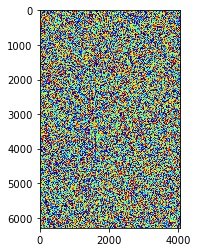

In [2]:

#画像の位置合わせを行う関数
def coregistration(A,B,C,D):
    py = len(A)
    px = len(A[0])
    A = np.float64(A)
    B = np.float64(B)
    d, etc = cv2.phaseCorrelate(B,A)
    dx, dy = d
    if dx >= 0 and dy >= 0:
        dx = int(np.round(dx))
        dy = int(np.round(dy))
        rD = D[0:py-dy,0:px-dx]
        rC = C[dy:py,dx:px]   
    elif dx < 0 and dy >= 0:
        dx = int(np.round(dx))
        dy = int(np.round(dy))
        rD = D[0:py-dy,abs(dx):px]
        rC = C[dy:py,0:px-abs(dx)]   
    return rC, rD

def wraptopi(x):
    x = x - np.floor(x/(2*np.pi))*2*np.pi - np.pi
    return x

def main():
    phase01 = np.load('phase01.npy')
    sigma01 = np.load('sigma01.npy')
    phase02 = np.load('phase02.npy')
    sigma02 = np.load('sigma02.npy')

    coreg_phase01, coreg_phase02 = coregistration(sigma01,sigma02,phase01,phase02)
    ifgm = wraptopi(coreg_phase01 - coreg_phase02)
    np.save('ifgm.npy',ifgm)
    
    plt.figure()
    plt.imshow(ifgm, cmap = "jet", clim = [-np.pi,np.pi])
    plt.imsave('ifgm.png', ifgm, cmap = "jet")
    
if __name__=="__main__":
       main()


### 軌道情報を使って軌道縞を除去する

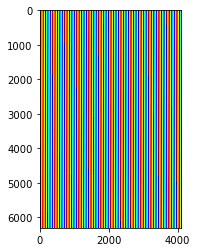

In [3]:

import scipy
from scipy.interpolate import interp1d

#観測中の衛星位置を出力する関数
def get_sat_pos(led,img):
    img.seek(720+44)
    time_start = struct.unpack(">i",img.read(4))[0]/1000
    led.seek(720+500)
    lam = float(led.read(16)) #m
    
    led.seek(720+4096+140)
    position_num = int(led.read(4))
    led.seek(720+4096+182)
    time_interval = int(float(led.read(22)))
    
    led.seek(720+4096+160)
    start_time = float(led.read(22))
    
    led.seek(720+68)    
    center_time = led.read(32)
    Hr = float(center_time[8:10])*3600
    Min = float(center_time[10:12])*60
    Sec = float(center_time[12:14])
    msec = float(center_time[14:17])*1e-3
    center_time = Hr+Min+Sec+msec;
    time_end = time_start + (center_time - time_start)*2;
    
    img.seek(236)
    nline = int(img.read(8))
    time_obs = np.arange(time_start, time_end, (time_end - time_start)/nline)
    time_pos = np.arange(start_time, start_time+time_interval*position_num,time_interval)
    pos_ary = [];
    
    led.seek(720+4096+386)
    for i in range(position_num):
        for j in range(3):
            pos = float(led.read(22))
            pos_ary.append(pos)
        led.read(66)
    pos_ary = np.array(pos_ary).reshape(-1,3)

    fx = scipy.interpolate.interp1d(time_pos,pos_ary[:,0],kind="cubic")
    fy = scipy.interpolate.interp1d(time_pos,pos_ary[:,1],kind="cubic")
    fz = scipy.interpolate.interp1d(time_pos,pos_ary[:,2],kind="cubic")
    X = fx(time_obs)
    Y = fy(time_obs)
    Z = fz(time_obs)
    XYZ = np.zeros(nline*3).reshape(-1,3)
    XYZ[:,0] = X
    XYZ[:,1] = Y
    XYZ[:,2] = Z
    return XYZ

#軌道縞を生成する関数
def get_orbit_stripe(pos1,pos2,pl,led):
    led.seek(720+500)
    lam = float(led.read(16)) # [m]    
    a = []
    b = []
    c = []
    led.seek(720+4096+1620+4680+16384+9860+325000+511000+3072+728000+1024)
    for i in range(25):
        a.append(float(led.read(20)))
    for i in range(25):
        b.append(float(led.read(20)))
    for i in range(2):
        c.append(float(led.read(20)))
    npix = pl[1]-pl[0]
    nline = pl[3]-pl[2]
    orb = np.zeros((nline,npix))
    for i in range(npix):
        for j in range(nline):
            px = i+pl[0]-c[0]
            ln = j+pl[2]-c[1]
            ilat = (a[0]*ln**4 + a[1]*ln**3 + a[2]*ln**2 + a[3]*ln + a[4])*px**4 + (a[5]*ln**4 + a[6]*ln**3 + a[7]*ln**2 + a[8]*ln + a[9])*px**3 + (a[10]*ln**4 + a[11]*ln**3 + a[12]*ln**2 + a[13]*ln + a[14])*px**2 + (a[15]*ln**4 + a[16]*ln**3 + a[17]*ln**2 + a[18]*ln + a[19])*px + a[20]*ln**4 + a[21]*ln**3 + a[22]*ln**2 + a[23]*ln + a[24]
            ilon = (b[0]*ln**4 + b[1]*ln**3 + b[2]*ln**2 + b[3]*ln + b[4])*px**4 + (b[5]*ln**4 + b[6]*ln**3 + b[7]*ln**2 + b[8]*ln + b[9])*px**3 + (b[10]*ln**4 + b[11]*ln**3 + b[12]*ln**2 + b[13]*ln + b[14])*px**2 + (b[15]*ln**4 + b[16]*ln**3 + b[17]*ln**2 + b[18]*ln + b[19])*px + b[20]*ln**4 + b[21]*ln**3 + b[22]*ln**2 + b[23]*ln + b[24]
            ixyz = lla2ecef(ilat*np.pi/180.0,ilon*np.pi/180.0,0)
            r1 = np.linalg.norm(pos1[j+pl[2],:] - ixyz);
            r2 = np.linalg.norm(pos2[j+pl[2],:] - ixyz);
            orb[j,i] = wraptopi(2*np.pi/lam*2*(r2-r1));
    return orb

#緯度経度高度から地球のECEF座標系のXYZを出力する関数
def lla2ecef(lat,lon,alt):
    a = 6378137.0
    f = 1 / 298.257223563
    e2 = 1 - (1 - f) * (1 - f)
    v = a / math.sqrt(1 - e2 * math.sin(lat) * math.sin(lat))

    x = (v + alt) * math.cos(lat) * math.cos(lon)
    y = (v + alt) * math.cos(lat) * math.sin(lon)
    z = (v * (1 - e2) + alt) * math.sin(lat)
    return np.array([x,y,z])

def main():
    dataset_id = 'ALOS2176170700-170827' #Mt.Fuji
    fpimg = open(os.path.join(dataset_id,'IMG-HH-'+dataset_id+'-HBQR1.1__A'),mode='rb')
    fpled = open(os.path.join(dataset_id,'LED-'+dataset_id+'-HBQR1.1__A'),mode='rb')
    pos1 = get_sat_pos(fpled,fpimg)    

    dataset_id = 'ALOS2229990700-180826' #Mt.Fuji
    fpimg = open(os.path.join(dataset_id,'IMG-HH-'+dataset_id+'-HBQR1.1__A'),mode='rb')
    fpled = open(os.path.join(dataset_id,'LED-'+dataset_id+'-HBQR1.1__A'),mode='rb')
    pos2 = get_sat_pos(fpled,fpimg)    
    
    pl = [2050, 6150, 6450, 12750]

    orbit_stripe = get_orbit_stripe(pos1,pos2,pl,fpled)
    np.save('orbit_stripe.npy',orbit_stripe)
    
    plt.figure()
    plt.imshow(orbit_stripe, cmap = "jet", clim = [-np.pi,np.pi])
    plt.imsave('orbit_stripe.png', orbit_stripe, cmap = "jet")
    
if __name__=="__main__":
       main()


この軌道縞を干渉画像から差し引いて、軌道縞を除去します

In [10]:
def main():
    ifgm = np.load('ifgm.npy')
    orbit_stripe = np.load('orbit_stripe.npy')

#軌道縞の画像サイズをインターフェログラムのサイズと合わせます
    orbit_stripe = orbit_stripe[0:ifgm.shape[0],0:ifgm.shape[1]]
    ifgm_sub_orb = wraptopi(ifgm - orbit_stripe) #軌道縞除去の処理
    np.save('ifgm_sub_orb.npy',ifgm_sub_orb)
    
    plt.figure()
    plt.imsave('ifgm_sub_orb.jpg', ifgm_sub_orb, cmap = "jet")

if __name__=="__main__":
       main()

<Figure size 432x288 with 0 Axes>

### DEMによる軌道縞の除去

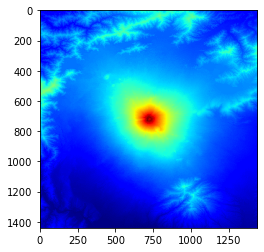

In [6]:

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from osgeo import gdal, gdalconst, gdal_array

def main():
    tif = gdal.Open('ALPSMLC30_N035E138_DSM.tif', gdalconst.GA_ReadOnly)
    dem = tif.GetRasterBand(1).ReadAsArray(0,0,3600,3600)
    
    N = 35#DEMの北緯
    E = 138#DEMの東経
    P = 3600#DEMのピクセル数
    
    lat = np.linspace(N+1,N,P);
    lon = np.linspace(E,E+1,P);
    
    latlon = [35.163, 35.563, 138.530, 138.930]#富士山山頂を中心とした±0.2度のLat/Lon
    top_lat = int(np.fix(P-(latlon[1]-N)*P))
    bottom_lat = int(np.fix(P-(latlon[0]-N)*P))
    left_lon = int(np.fix((latlon[2]-E)*P)-1)
    right_lon = int(np.fix((latlon[3]-E)*P))

    #上記の情報を使ってDEMをカットする
    dem = dem[top_lat:bottom_lat,left_lon:right_lon]
    lat = lat[top_lat:bottom_lat]
    lon = lon[left_lon:right_lon]

    np.save('dem_cut.npy',dem)
    np.save('lat.npy',lat)
    np.save('lon.npy',lon)

    plt.imshow(dem, cmap = "jet", clim = [0,3771])
    plt.imsave('dem_cut.png', dem, cmap = "hsv")

if __name__=="__main__":
       main()


### 地形縞をシミュレート
地平面上の距離（グランドレンジ）と、電波の経路（スラントレンジ）の座標変換

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from osgeo import gdal, gdalconst, gdal_array

def main():

    dem = np.load('dem_cut.npy')
    lat = np.load('lat.npy')
    lon = np.load('lon.npy')

    #衛星座標（シーンセンタ固定）
    satpos0c = [-4078.581984e3, 4081.311933e3, 3974.603863e3]
    satpos1c = [-4078.383306e3, 4081.518669e3, 3974.563115e3]
    
    Fc = 1257.5e6
    CVEL = 3e8
    lam = CVEL/Fc
    
    geo_resample = np.zeros(np.shape(dem)) #幾何補正パラメータ
    terrain_stripe = np.zeros(np.shape(dem)) #地形縞シミュレート

    for i in range(len(lat)):
        if i % 100 == 0:
            print(i,len(lat))
        for j in range(len(lon)):
            ixyz = lla2ecef(np.deg2rad(lat[i]),np.deg2rad(lon[j]),dem[i,j]+50.0) #DEMの座標(50mはジオイド高)
            fxyz = lla2ecef(np.deg2rad(lat[i]),np.deg2rad(lon[j]),50.0) #楕円球体の座標
            r0 = np.linalg.norm(satpos0c - ixyz)
            r1 = np.linalg.norm(satpos1c - ixyz)
            f0 = np.linalg.norm(satpos0c - fxyz)
            f1 = np.linalg.norm(satpos1c - fxyz)
            terrain_stripe[i,j] = wraptopi(4*np.pi/lam*4*(r1-r0-(f1-f0)))
            geo_resample[i,j] = r0
        geo_resample[i,:] = (geo_resample[i,:]-min(geo_resample[i,:]))/(max(geo_resample[i,:])-min(geo_resample[i,:]))

    np.save('geo_resample.npy',geo_resample)
    np.save('terrain_stripe.npy',terrain_stripe)
    plt.imsave('terrain_stripe.png', terrain_stripe, cmap = "hsv")

if __name__=="__main__":
       main()

0 1440
100 1440
200 1440
300 1440
400 1440
500 1440
600 1440
700 1440
800 1440
900 1440
1000 1440
1100 1440
1200 1440
1300 1440
1400 1440


### 地形縞を干渉画像にフィットさせる

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from scipy import interpolate

def main():
    terrain = np.load('terrain_stripe.npy')
    terrain = np.rot90(terrain,-1)#干渉画像と向きを合わせるため90度行列を回転
    
    #①地形縞の回転
    center = (int(terrain.shape[1]/2),int(terrain.shape[0]/2))
    angle = -10.0
    trans = cv2.getRotationMatrix2D(center, angle, 1.0) #時計回りに10度回転
    terrain_rot = cv2.warpAffine(terrain, trans, (terrain.shape[1],terrain.shape[0]))
    plt.imsave('terrain_rot.png', terrain_rot, cmap = "hsv")
    
    resample = np.load('geo_resample.npy')
    resample = np.rot90(resample,-1)

    #②幾何補正
    for i in range(np.shape(resample)[1]):
        f = interpolate.interp1d(resample[:,i],terrain_rot[:,i])
        terrain_rot[:,i] = f(np.linspace(0,1,np.shape(resample)[0]))
    plt.imsave('terrain_geo.png', terrain_rot, cmap = "hsv")

    #③干渉画像にフィットするようにカット
    dem = terrain_rot[150:980,435:1065]
    np.save('dem_fit.npy',dem)
    plt.imsave('dem_fit.png', dem, cmap = "hsv")
    
if __name__=="__main__":
       main()

### DEMからシミュレートした地形縞の解像度を補間

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

def main():

    dem = np.load('dem_fit.npy')
    ifgm = np.load('ifgm_sub_orb.npy')
    ifgm = np.fliplr(np.rot90(ifgm,-1))

    NY = np.shape(ifgm)[0];
    NX = np.shape(ifgm)[1];

    posY = np.linspace(1,np.shape(dem)[0]-1,NY);
    posX = np.linspace(1,np.shape(dem)[1]-1,NX);
    
    #解像度のリサンプリング（バイリニア補間）
    dem_res = np.zeros([NY,NX]);
    for i in range(NY):
        iy = int(np.fix(posY[i]))
        dy = posY[i]-iy
        for j in range(NX):
            ix = int(np.fix(posX[j]))
            dx = posX[j]-ix
            dem_res[i,j] = (1-dx)*(1-dy)*dem[iy-1,ix-1]+dx*(1-dy)*dem[iy-1,ix]+(1-dx)*dy*dem[iy,ix-1]+dy*dx*dem[iy,ix]
    
    np.save('dem_res.npy',dem_res)
    plt.imsave('dem_res.png', dem_res, cmap = "hsv")
    
if __name__=="__main__":
       main()

In [ ]:
### 地形縞を除去してみよう！

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

def main():
    ifgm = np.load('ifgm_sub_orb.npy')
    ifgm = np.fliplr(np.rot90(ifgm,-1))
    plt.imsave('ifgm_fliplr.png', ifgm, cmap = "hsv")
    dem = np.load('dem_res.npy')
    
    #干渉画像から地形縞を除去する
    ifgm_sub_dem = wraptopi(ifgm - dem)
    
    np.save('ifgm_sub_dem.npy',ifgm_sub_dem)
    plt.imsave('ifgm_sub_dem.png', ifgm_sub_dem, cmap = "hsv")
    
if __name__=="__main__":
       main()